In [1]:
# Dependencies
import numpy as np
import pandas as pd
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.manifold import TSNE
from collections import Counter
from six.moves import cPickle
import gensim.models.word2vec as w2v
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
import io
import re
import json
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
training_drop_na_df = pd.read_csv(r"C:\Users\jjtre\Documents\UCSD Coding Bootcamp Data Science\Final Project\testing_cleaned_tweets_stopword_filter_dropnan.csv", encoding='utf-8')
training_drop_na_df.head()

,tweet_polarity,tweet_text,clean_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [3]:
training_drop_na_df.dtypes

tweet_polarity     int64
tweet_text        object
clean_tweets      object
dtype: object

In [4]:
training_drop_na_df['tweet_polarity'].value_counts()

4    796299
0    796229
Name: tweet_polarity, dtype: int64

In [5]:
# make a smaller cut of dataframe to test... way to long to run the whole model
# try 25K neg and pos
neg_df = training_drop_na_df.iloc[0:25000] # first 25K rows of dataframe
neg_df.head()

,tweet_polarity,tweet_text,clean_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [6]:
len(neg_df)

25000

In [7]:
# make a smaller cut of dataframe to test... way too long to run the whole model
# try 25K neg and pos
pos_df = training_drop_na_df.iloc[796229:821229] # first 25K rows of positive tweets
pos_df.head()

,tweet_polarity,tweet_text,clean_tweets
796229,4,I LOVE @Health4UandPets u guys r the best!!,love u guys r best
796230,4,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
796231,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...
796232,4,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...
796233,4,@LovesBrooklyn2 he has that effect on everyone,effect everyone


In [8]:
len(pos_df)

25000

In [9]:
# join the two dataframes
join_neg_pos_df = pd.concat([neg_df, pos_df], ignore_index=True)
join_neg_pos_df.head()

,tweet_polarity,tweet_text,clean_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving mad see


In [10]:
print(len(join_neg_pos_df))

50000


In [11]:
# Tokenizer to vectorize the text and convert it into sequence of integers after restricting the tokenizer to use only top most common 2000 words
tokenizer = Tokenizer(num_words=2000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(join_neg_pos_df['clean_tweets'].values)

In [12]:
tokenizer

In [13]:
# pad_sequences to convert the sequences into 2-D numpy array
X = tokenizer.texts_to_sequences(join_neg_pos_df['clean_tweets'].values)
X = pad_sequences(X)

In [14]:
len(join_neg_pos_df)

50000

In [15]:
# built LSTM network
# hyperparameters
# embed_dim : The embedding layer encodes the input sequence into a sequence of dense vectors of dimension embed_dim
# lstm_out : The LSTM transforms the vector sequence into a single vector of size lstm_out, containing information about the entire sequence.
from keras.layers import SpatialDropout1D

embed_dim = 128
lstm_out = 196
#batch_size = 128

model = Sequential()
model.add(Embedding(2000, embed_dim, input_length = X.shape[1])) # , dropout = 0.2
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  #lstm_out, dropout_U = 0.2, dropout_W = 0.2
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

W0926 01:02:21.127618    92 deprecation_wrapper.py:119] From C:\Users\jjtre\Anaconda3\envs\PythonData\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0926 01:02:21.132606    92 deprecation_wrapper.py:119] From C:\Users\jjtre\Anaconda3\envs\PythonData\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 01:02:21.135599    92 deprecation_wrapper.py:119] From C:\Users\jjtre\Anaconda3\envs\PythonData\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 01:02:21.159568    92 deprecation_wrapper.py:119] From C:\Users\jjtre\Anaconda3\envs\PythonData\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 21, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 387,842
Trainable params: 387,842
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# y values neg(0), pos(4) to 0, 1 one hot encoding
# 80/20 split
y = pd.get_dummies(join_neg_pos_df['tweet_polarity']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 21) (40000, 2)
(10000, 21) (10000, 2)


In [31]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 2, verbose = 2, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/2
 - 18s - loss: 0.3372 - acc: 0.8411 - val_loss: 0.6397 - val_acc: 0.7448
Epoch 2/2
 - 22s - loss: 0.3268 - acc: 0.8462 - val_loss: 0.6411 - val_acc: 0.7368


In [32]:
model

In [33]:
score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 128)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.5f" % (acc))

Score: 0.75
Validation Accuracy: 0.71290


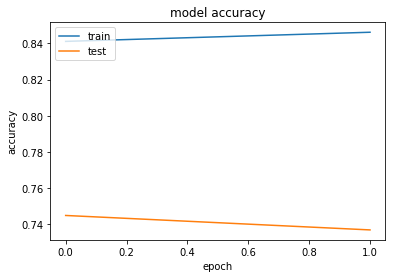

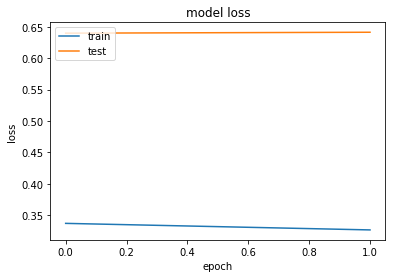

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [35]:
# Save the model
model.save("LSTM_model_trained.h5")